# DeepMatch 样例代码
- https://github.com/shenweichen/DeepMatch
- https://deepmatch.readthedocs.io/en/latest/

# 下载movielens-1M数据 安装依赖包

In [1]:
! wget http://files.grouplens.org/datasets/movielens/ml-1m.zip -O ./ml-1m.zip 
! wget https://raw.githubusercontent.com/shenweichen/DeepMatch/master/examples/preprocess.py -O preprocess.py
! unzip -o ml-1m.zip 
# ! pip uninstall -y -q tensorflow
# ! pip install -q tensorflow-gpu==2.5.0
# ! pip install -q deepmatch

--2024-05-13 17:38:02--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
正在查找主機 files.grouplens.org (files.grouplens.org)... 128.101.65.152
正在連接 files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... 連上了。
已送出 HTTP 要求，正在等候回應... 200 OK
長度: 5917549 (5.6M) [application/zip]
儲存到：「./ml-1m.zip」

./ml-1m.zip         100%[===================>]   5.64M  1.41MB/s  於 4.7s       

2024-05-13 17:38:08 (1.20 MB/s) - 已儲存 「./ml-1m.zip」 [5917549/5917549]

--2024-05-13 17:38:08--  https://raw.githubusercontent.com/shenweichen/DeepMatch/master/examples/preprocess.py
正在查找主機 raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
正在連接 raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... 連上了。
已送出 HTTP 要求，正在等候回應... 200 OK
長度: 6705 (6.5K) [text/plain]
儲存到：「preprocess.py」

preprocess.py       100%[===================>]   6.55K  --.-KB/s  於 0s         

2024-05-13 17:38:08 (22.6 MB/s) - 已儲存 「preprocess.py」 [6705/670

# 导入需要的库

In [1]:
import pandas as pd
from deepctr.feature_column import SparseFeat, VarLenSparseFeat
from preprocess import gen_data_set, gen_model_input
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model

from deepmatch.models import *
from deepmatch.utils import sampledsoftmaxloss, NegativeSampler

In [2]:
from IPython.display import display

# 读取数据

In [3]:
!ls

__pycache__
colab_MovieLen1M_ComiRec.ipynb
colab_MovieLen1M_DSSM_InBatchSoftmax.ipynb
colab_MovieLen1M_SDM.ipynb
colab_MovieLen1M_YoutubeDNN.ipynb
ml-1m
ml-1m.zip
movielens_sample.txt
preprocess.py
run_dssm_inbatchsoftmax.py
run_dssm_negsampling.py
run_ncf.py
run_sdm.py
run_youtubednn.py


In [4]:
data_path = "./"

unames = ['user_id','gender','age','occupation','zip']
user = pd.read_csv(data_path+'ml-1m/users.dat',sep='::',header=None,names=unames)
rnames = ['user_id','movie_id','rating','timestamp']
ratings = pd.read_csv(data_path+'ml-1m/ratings.dat',sep='::',header=None,names=rnames)
mnames = ['movie_id','title','genres']
movies = pd.read_csv(data_path+'ml-1m/movies.dat',sep='::',header=None,names=mnames,encoding="unicode_escape")
movies['genres'] = list(map(lambda x: x.split('|')[0], movies['genres'].values))

data = pd.merge(pd.merge(ratings,movies),user).iloc[:10000]
# data = pd.merge(pd.merge(ratings,movies),user)

/var/folders/zk/7_lr6y6s5wx2pcwhkjyfln3m0000gn/T/ipykernel_34583/1533986894.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  user = pd.read_csv(data_path+'ml-1m/users.dat',sep='::',header=None,names=unames)
/var/folders/zk/7_lr6y6s5wx2pcwhkjyfln3m0000gn/T/ipykernel_34583/1533986894.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv(data_path+'ml-1m/ratings.dat',sep='::',header=None,names=rnames)
/var/folders/zk/7_lr6y6s5wx2pcwhkjyfln3m0000gn/T/ipykernel_34583/1533986894.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separa

In [5]:
display(
    data.shape,
    data.head(),
    data.describe(include='all'),
    'movie_ids : ',
    data.movie_id.nunique(),
    'user_ids : ',  
    data.user_id.nunique()
)

(10000, 10)

,user_id,movie_id,rating,timestamp,title,genres,gender,age,occupation,zip
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),Animation,F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),Musical,F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation,F,1,10,48067


,user_id,movie_id,rating,timestamp,title,genres,gender,age,occupation,zip
count,10000.000000,10000.000000,10000.000000,1.000000e+04,10000,10000,10000,10000.000000,10000.000000,10000
unique,NaN,NaN,NaN,NaN,2175,18,2,NaN,NaN,46
top,NaN,NaN,NaN,NaN,One Flew Over the Cuckoo's Nest (1975),Comedy,M,NaN,NaN,96931
freq,NaN,NaN,NaN,NaN,46,2536,6866,NaN,NaN,684
mean,91.362900,1840.557700,3.647900,9.807671e+08,NaN,NaN,NaN,28.936300,7.295300,NaN
std,54.252804,1075.377234,1.052728,1.120014e+07,NaN,NaN,NaN,11.553536,6.484219,NaN
min,1.000000,1.000000,1.000000,9.770896e+08,NaN,NaN,NaN,1.000000,0.000000,NaN
25%,48.000000,1030.750000,3.000000,9.774469e+08,NaN,NaN,NaN,25.000000,2.000000,NaN
50%,81.000000,1732.500000,4.000000,9.779737e+08,NaN,NaN,NaN,25.000000,4.000000,NaN
75%,146.000000,2722.000000,4.000000,9.781587e+08,NaN,NaN,NaN,35.000000,10.000000,NaN


'movie_ids : '

2175

'user_ids : '

46

# 构建特征列，训练模型，导出embedding

In [6]:
#data = pd.read_csvdata = pd.read_csv("./movielens_sample.txt")
sparse_features = ["movie_id", "user_id",
                    "gender", "age", "occupation", "zip", "genres"]
SEQ_LEN = 50
negsample = 0

# 1.Label Encoding for sparse features,and process sequence features with `gen_date_set` and `gen_model_input`

feature_max_idx = {}
for feature in sparse_features:
    lbe = LabelEncoder()
    data[feature] = lbe.fit_transform(data[feature]) + 1
    feature_max_idx[feature] = data[feature].max() + 1

user_profile = data[["user_id", "gender", "age", "occupation", "zip"]].drop_duplicates('user_id')

item_profile = data[["movie_id"]].drop_duplicates('movie_id')

user_profile.set_index("user_id", inplace=True)

user_item_list = data.groupby("user_id")['movie_id'].apply(list)

train_set, test_set = gen_data_set(data, SEQ_LEN, negsample)

train_model_input, train_label = gen_model_input(train_set, user_profile, SEQ_LEN)
test_model_input, test_label = gen_model_input(test_set, user_profile, SEQ_LEN)

100%|█████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 552.40it/s]
/Users/yulongtsai/Desktop/Working_Area/DeepMatch/examples/preprocess.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  train_seq_genres = np.array([line[5] for line in train_set])


8 8


In [22]:
# sampler_config

In [7]:


# 2.count #unique features for each sparse field and generate feature config for sequence feature

embedding_dim = 32

user_feature_columns = [SparseFeat('user_id', feature_max_idx['user_id'], 16),
                        SparseFeat("gender", feature_max_idx['gender'], 16),
                        SparseFeat("age", feature_max_idx['age'], 16),
                        SparseFeat("occupation", feature_max_idx['occupation'], 16),
                        SparseFeat("zip", feature_max_idx['zip'], 16),
                        VarLenSparseFeat(SparseFeat('hist_movie_id', feature_max_idx['movie_id'], embedding_dim,
                                                    embedding_name="movie_id"), SEQ_LEN, 'mean', 'hist_len'),
                        VarLenSparseFeat(SparseFeat('hist_genres', feature_max_idx['genres'], embedding_dim,
                                                   embedding_name="genres"), SEQ_LEN, 'mean', 'hist_len'),
                        ]

# item 只有 id，沒有對應的 item features
item_feature_columns = [SparseFeat('movie_id', feature_max_idx['movie_id'], embedding_dim)]

from collections import Counter
train_counter = Counter(train_model_input['movie_id'])
item_count = [train_counter.get(i,0) for i in range(item_feature_columns[0].vocabulary_size)]
sampler_config = NegativeSampler('frequency',num_sampled=255,item_name="movie_id",item_count=item_count)

# 3.Define Model and train

import tensorflow as tf
if tf.__version__ >= '2.0.0':
    tf.compat.v1.disable_eager_execution()
else:
    K.set_learning_phase(True)
    
model = YoutubeDNN(user_feature_columns, item_feature_columns, user_dnn_hidden_units=(128,64, embedding_dim), sampler_config=sampler_config)
#model = MIND(user_feature_columns,item_feature_columns,dynamic_k=False,k_max=2, user_dnn_hidden_units=(128,64, embedding_dim), sampler_config=sampler_config)

# sampledsoftmaxloss - important loss function apply negative sampling for multi-classes
model.compile(optimizer="adam", loss=sampledsoftmaxloss)

history = model.fit(train_model_input, train_label,  # train_label,
                    batch_size=512, epochs=20, verbose=1, validation_split=0.0, )

# 4. Generate user features for testing and full item features for retrieval
test_user_model_input = test_model_input
all_item_model_input = {"movie_id": item_profile['movie_id'].values,}

user_embedding_model = Model(inputs=model.user_input, outputs=model.user_embedding)
item_embedding_model = Model(inputs=model.item_input, outputs=model.item_embedding)

user_embs = user_embedding_model.predict(test_user_model_input, batch_size=2 ** 12)
# user_embs = user_embs[:, i, :]  # i in [0,k_max) if MIND
item_embs = item_embedding_model.predict(all_item_model_input, batch_size=2 ** 12)

print(user_embs.shape)
print(item_embs.shape)

Train on 9908 samples
Epoch 1/20


2024-05-14 11:57:47.790847: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


9908/9908 [==============================] - 1s 66us/sample - loss: 11.8385
Epoch 2/20
9908/9908 [==============================] - 0s 27us/sample - loss: 9.2014
Epoch 3/20
9908/9908 [==============================] - 0s 29us/sample - loss: 8.7334
Epoch 4/20
9908/9908 [==============================] - 0s 26us/sample - loss: 8.3460
Epoch 5/20
9908/9908 [==============================] - 0s 27us/sample - loss: 7.8493
Epoch 6/20
9908/9908 [==============================] - 0s 27us/sample - loss: 7.4769
Epoch 7/20
9908/9908 [==============================] - 0s 27us/sample - loss: 7.1053
Epoch 8/20
9908/9908 [==============================] - 0s 28us/sample - loss: 6.9057
Epoch 9/20
9908/9908 [==============================] - 0s 27us/sample - loss: 6.4999
Epoch 10/20
9908/9908 [==============================] - 0s 27us/sample - loss: 6.2812
Epoch 11/20
9908/9908 [==============================] - 0s 28us/sample - loss: 6.0093
Epoch 12/20
9908/9908 [==============================] - 0s 28

/Users/yulongtsai/opt/miniconda3/envs/deep_match_38/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [21]:
user_embs[0], item_embs[0]

(array([-0.06659417,  0.06063242, -0.03848748, -0.28001413,  0.03008841,
        -0.02134304, -0.02421067,  0.09181335,  0.00747757, -0.03091125,
        -0.07595862, -0.02044039,  0.08409872,  0.06073863, -0.1624648 ,
        -0.34542832,  0.49704835,  0.23406592, -0.03664735,  0.05653051,
         0.08093211,  0.08394654,  0.17315595, -0.0608228 ,  0.2691896 ,
         0.26729694,  0.11697683,  0.3412756 ,  0.29095942, -0.00721809,
         0.04854968,  0.15216674], dtype=float32),
 array([-0.17227949,  0.12590104, -0.11971793, -0.28937042,  0.10706939,
        -0.18632875, -0.11351259, -0.01100992,  0.06729872,  0.02495824,
         0.00294563,  0.04439833,  0.07902899,  0.25324842,  0.12017913,
        -0.15498243,  0.53053665,  0.13115574, -0.09373093,  0.02526599,
         0.08486939,  0.2228344 ,  0.16989477,  0.08697134,  0.16997184,
         0.27082318,  0.01734922,  0.29934275,  0.19565178,  0.1241786 ,
        -0.01920863,  0.18342562], dtype=float32))

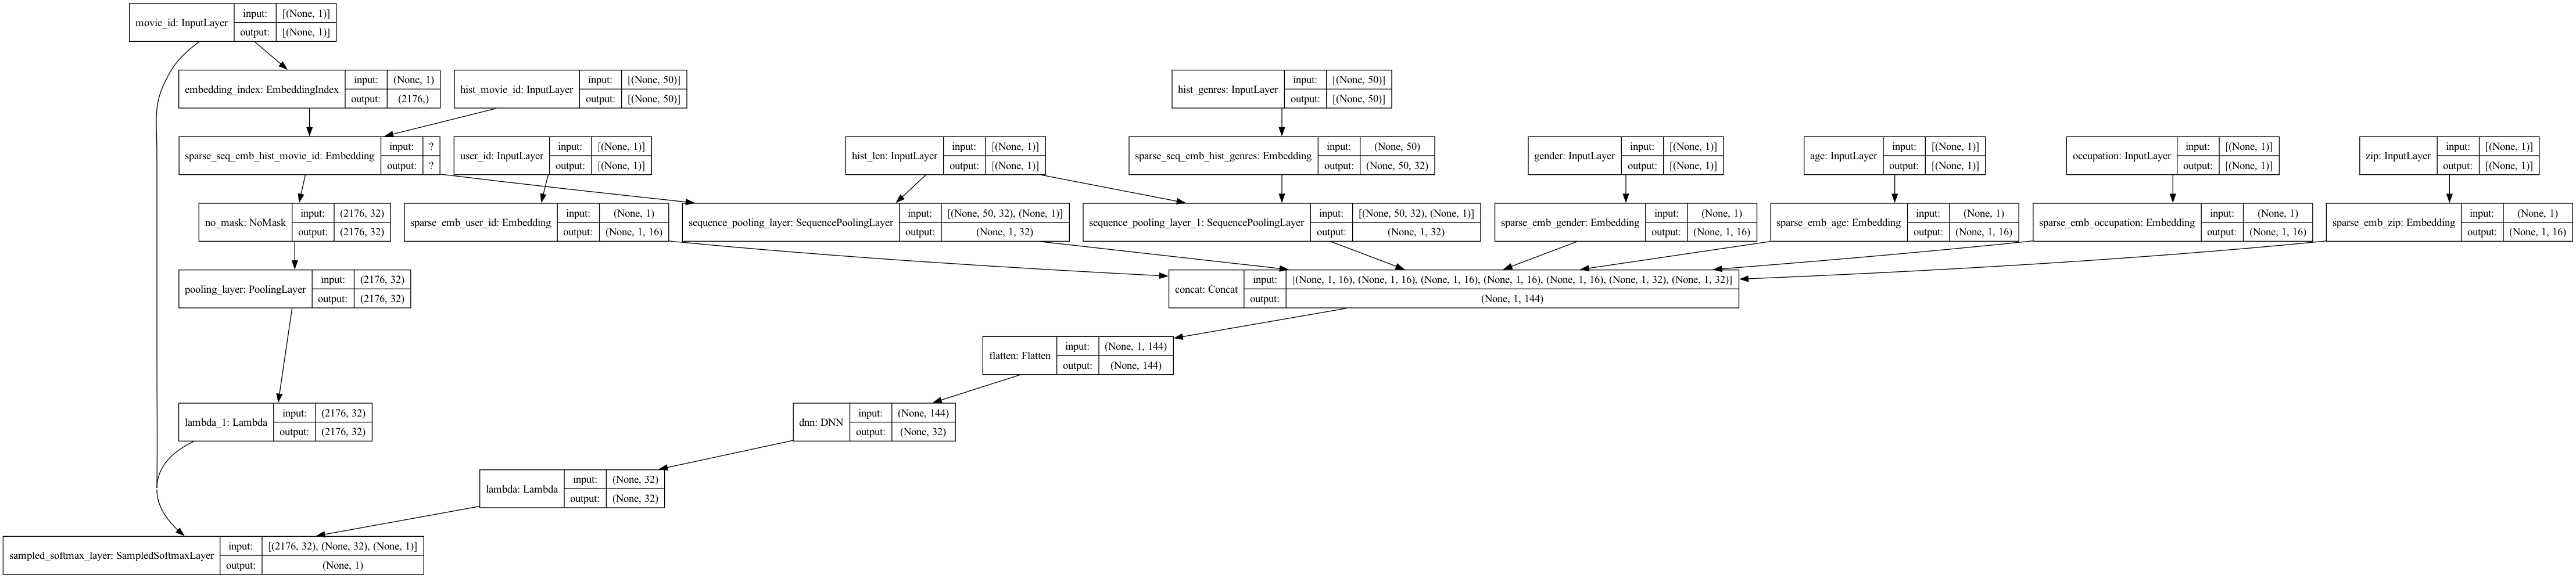

In [8]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,layer_range=None,
    # show_layer_activatinotallow=True
    )

# 使用faiss进行ANN查找并评估结果

In [10]:
# ! pip install faiss-cpu

In [11]:
len(test_set)

46

In [12]:
test_true_label = {line[0]:[line[1]] for line in test_set}

import numpy as np
import faiss
from tqdm import tqdm
from deepmatch.utils import recall_N

index = faiss.IndexFlatIP(embedding_dim)
# faiss.normalize_L2(item_embs)
index.add(item_embs)
# faiss.normalize_L2(user_embs)
# query = user embedding
# indexes = item embedding
D, I = index.search(np.ascontiguousarray(user_embs), 50)
s = []
hit = 0
for i, uid in tqdm(enumerate(test_user_model_input['user_id'])):
    try:
        pred = [item_profile['movie_id'].values[x] for x in I[i]]
        filter_item = None
        recall_score = recall_N(test_true_label[uid], pred, N=50)
        s.append(recall_score)
        if test_true_label[uid] in pred:
            hit += 1
    except:
        print(i)
print("")
print("recall", np.mean(s))
print("hit rate", hit / len(test_user_model_input['user_id']))

46it [00:00, 2016.05it/s]


recall 0.15217391304347827
hit rate 0.15217391304347827


In [13]:
test_user_model_input.keys()

dict_keys(['user_id', 'movie_id', 'hist_movie_id', 'hist_genres', 'hist_len', 'genres', 'gender', 'age', 'occupation', 'zip'])

In [ ]:
# Q&A

# Instance (y)
# Retrieval - which video will be watched next?
# seqeuntial features like watch histroy, search history (use mean pooling, we could use attention now)
# user-viewed (i1, i2, i3), we could produce 2 examples
    # user-i1 : i2,
    # user-i1,i2, : i3

# Feature Engineering (x)
# Retrieval
# ExampleAge
# not used here, basically viewed_since_upload_hours
# inference - set to zero - user like new video, so there is a new video bias (like positional bias)

# Ranking
# y - expected watch time per imprerssion of user-video
# time since last eatch (channel)
# num_previous impression

# Network Arct
# Could it expand item-side information and user-side information?
# Negative Sampler - Is it actually work as loss function level
    # Yes, its a loss func
    # we can define the negtive sampler to give Q(y|x)

# Serving
# Serving format of item embedding - N dimension vectors
# The Serving Format of user embedding - N dimension vectors

# Fresh features could be streaming by realtime-data-pipeline
# Item features is more likely to be static
# New Video need a cold-start- method (find most K similar and take mean of the video)

# Item Profile still needs to be added...